# Importing libraries

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Cleaning and Preprocessing

In [3]:
# Connect to SQLite database
conn = sqlite3.connect('films.db')
# Querying the database

#Here we convert from sql tables to pandas tables
query = "SELECT * FROM title_ratings WHERE tconst IN (SELECT tb.tconst FROM title_basics AS tb WHERE tb.titleType = 'movie')"
df_title_ratings = pd.read_sql_query(query, conn)
df_title_ratings.replace("\\N", np.nan, inplace=True)

query = "SELECT nconst, primaryName FROM name_basics"
df_name_basics = pd.read_sql_query(query, conn)
df_name_basics.replace("\\N", np.nan, inplace=True)

query = "SELECT titleid, COUNT(CASE WHEN isOriginalTitle = 0 THEN 1 END) AS pocet_prekladov FROM title_akas GROUP BY titleid"
df_title_akas = pd.read_sql_query(query, conn)
df_title_akas.replace("\\N", np.nan, inplace=True)

query = "SELECT tconst, primaryTitle, isAdult, startYear, runtimeMinutes, genres  FROM title_basics WHERE titleType = 'movie'"
df_title_basics = pd.read_sql_query(query, conn)
df_title_basics.replace("\\N", np.nan, inplace=True)


query = """SELECT tconst, nconst, category 
            FROM title_principals 
            WHERE (category = 'actor' OR category = 'director') 
            AND tconst IN (SELECT tb.tconst FROM title_basics AS tb WHERE tb.titleType = 'movie')"""
df_title_principals = pd.read_sql_query(query, conn)
# Close the connection
conn.close()

#additional datasources 
df_top_actors = pd.read_csv('top20actors.csv')
df_best_directors = pd.read_csv('best_directors.csv')
df_worst_directors = pd.read_csv('worst_directors.csv')
df_disability = pd.read_csv('movies_disability.csv')

In [3]:
df_title_ratings.head()

tconst  averageRating  numVotes
0  tt0000009            5.3       207
1  tt0000147            5.3       489
2  tt0000502            4.1        15
3  tt0000574            6.0       862
4  tt0000591            5.0        21

In [4]:
df_title_akas.head()

titleId  pocet_prekladov
0  tt0000001                7
1  tt0000002                7
2  tt0000003                8
3  tt0000004                7
4  tt0000005               11

In [4]:
#Here we create a year_diff
df_title_basics['year_diff'] = df_title_basics['startYear']
df_title_basics['year_diff'] = df_title_basics['year_diff'].apply(lambda x: 2024 - int(x) if pd.notna(x) else np.nan)
df_title_basics.head()

tconst                   primaryTitle isAdult startYear runtimeMinutes  \
0  tt0000009                     Miss Jerry       0      1894             45   
1  tt0000147  The Corbett-Fitzsimmons Fight       0      1897            100   
2  tt0000502                       Bohemios       0      1905            100   
3  tt0000574    The Story of the Kelly Gang       0      1906             70   
4  tt0000591               The Prodigal Son       0      1907             90   

                       genres  year_diff  
0                     Romance      130.0  
1      Documentary,News,Sport      127.0  
2                         NaN      119.0  
3  Action,Adventure,Biography      118.0  
4                       Drama      117.0

### Defining "oblubenost" (score)

In [5]:
#log_score = avgRating*log(numvotes)
#norm_score = (avgRating/max(avgRating))*(numVotes/max(numVotes))
#prag_score = (avgRating*numVotes)/(avg(avgRating)*(avg(numVotes)))
df_title_ratings['log_score'] = df_title_ratings['averageRating'] * np.log(df_title_ratings['numVotes'])
df_title_ratings['norm_score'] = (df_title_ratings['averageRating'] / max(df_title_ratings['averageRating'])) * (df_title_ratings['numVotes'] / max(df_title_ratings['numVotes']))
df_title_ratings['prag_score'] = (df_title_ratings['averageRating'] * df_title_ratings['numVotes']) / (np.mean(df_title_ratings['averageRating']) * np.mean(df_title_ratings['numVotes'])) 

In [6]:
df_title_ratings.describe()

averageRating      numVotes      log_score    norm_score     prag_score
count  301868.000000  3.018680e+05  301868.000000  3.018680e+05  301868.000000
mean        6.175532  3.627837e+03      28.023937  8.984794e-04       1.136912
std         1.373577  3.584098e+04      14.541876  1.000128e-02      12.655354
min         1.000000  5.000000e+00       1.791759  2.116462e-07       0.000268
25%         5.300000  1.900000e+01      17.891328  4.137683e-06       0.005236
50%         6.300000  6.100000e+01      24.609682  1.314323e-05       0.016631
75%         7.100000  3.150000e+02      34.169375  6.213667e-05       0.078626
max        10.000000  2.834920e+06     138.174976  9.300000e-01    1176.797173

In [7]:
df = df_title_ratings[df_title_ratings['log_score'] > 130]
df.sort_values(by=['log_score'])

tconst  averageRating  numVotes   log_score  norm_score  \
78432   tt0167260            9.0   1941303  130.309830    0.616304   
36429   tt0068646            9.2   1975771  133.367517    0.641185   
136130  tt0468569            9.0   2816224  133.658168    0.894065   
61218   tt0111161            9.3   2834920  138.174976    0.930000   

         prag_score  
78432    779.854702  
36429    811.338891  
136130  1131.325470  
61218   1176.797173

In [8]:
df_title_ratings = df_title_ratings.drop('norm_score', axis=1)
df_title_ratings = df_title_ratings.drop('prag_score', axis=1)

### Creating a bigger unified table "df_films"

In [9]:
#here we join title_rating with title_akas on tconst
df_films = df_title_ratings.set_index('tconst').join(df_title_akas.set_index('titleId'), how='inner')
df_films = df_films.join(df_title_basics.set_index('tconst'), how='inner')

df_films['startYear'] = df_films['startYear'].apply(lambda x: int(x) if pd.notna(x) else np.nan)
df_films['runtimeMinutes'] = df_films['runtimeMinutes'].apply(lambda x: int(x) if pd.notna(x) else np.nan)
df_films['isAdult'] = df_films['isAdult'].apply(lambda x: int(x) if pd.notna(x) else np.nan)

df_films.head()

averageRating  numVotes  log_score  pocet_prekladov  \
tt0000009            5.3       207  28.263410                4   
tt0000147            5.3       489  32.819521                2   
tt0000502            4.1        15  11.103006                1   
tt0000574            6.0       862  40.555532                8   
tt0000591            5.0        21  15.222612                2   

                            primaryTitle  isAdult  startYear  runtimeMinutes  \
tt0000009                     Miss Jerry        0     1894.0            45.0   
tt0000147  The Corbett-Fitzsimmons Fight        0     1897.0           100.0   
tt0000502                       Bohemios        0     1905.0           100.0   
tt0000574    The Story of the Kelly Gang        0     1906.0            70.0   
tt0000591               The Prodigal Son        0     1907.0            90.0   

                               genres  year_diff  
tt0000009                     Romance      130.0  
tt0000147      Documentary,News,Sport      127.0  
tt0000502                         NaN      119.0  
tt0000574  Action,Adventure,Biography      118.0  
tt0000591                       Drama      117.0

In [10]:
df_films.describe()

averageRating      numVotes      log_score  pocet_prekladov  \
count  300814.000000  3.008140e+05  300814.000000    300814.000000   
mean        6.174886  3.637721e+03      28.047625         6.659291   
std         1.372649  3.590068e+04      14.545924         9.361295   
min         1.000000  5.000000e+00       1.791759         1.000000   
25%         5.300000  1.900000e+01      17.919531         1.000000   
50%         6.300000  6.200000e+01      24.642296         3.000000   
75%         7.100000  3.160000e+02      34.204877         7.000000   
max        10.000000  2.834920e+06     138.174976       249.000000   

             isAdult      startYear  runtimeMinutes      year_diff  
count  300814.000000  300777.000000   271352.000000  300777.000000  
mean        0.015461    1995.173404       94.472508      28.826596  
std         0.123379      25.895465      137.517464      25.895465  
min         0.000000    1894.000000        1.000000       1.000000  
25%         0.000000    1979.000000       81.000000       8.000000  
50%         0.000000    2005.000000       91.000000      19.000000  
75%         0.000000    2016.000000      103.000000      45.000000  
max         1.000000    2023.000000    51420.000000     130.000000

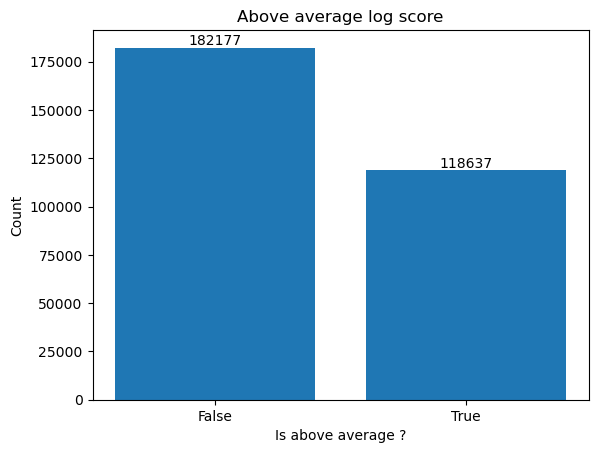

In [37]:
log_score_mean = df_films['log_score'].mean()
df_films['above_mean'] = df_films['log_score'] > log_score_mean
df_films.head()
counts = df_films['above_mean'].value_counts()

plt.bar(counts.index.astype(str), counts.values)

plt.xlabel('Is above average ?')
plt.ylabel('Count')
plt.title('Above average log score')

for i, count in enumerate(counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()
df_films = df_films.drop('above_mean', axis=1)

### Creating a table for genre combinations

In [11]:
df_genre_log = df_films.loc[:, ['primaryTitle', 'averageRating', 'numVotes', 'log_score', 'genres']]
df_genre_log['genres'] = df_genre_log['genres'].str.split(',')
df_genre_log['genres'] = df_genre_log['genres'].apply(lambda x: ",".join(sorted(x)) if isinstance(x, list) else np.nan)
df_genre_log.head()

primaryTitle  averageRating  numVotes  log_score  \
tt0000009                     Miss Jerry            5.3       207  28.263410   
tt0000147  The Corbett-Fitzsimmons Fight            5.3       489  32.819521   
tt0000502                       Bohemios            4.1        15  11.103006   
tt0000574    The Story of the Kelly Gang            6.0       862  40.555532   
tt0000591               The Prodigal Son            5.0        21  15.222612   

                               genres  
tt0000009                     Romance  
tt0000147      Documentary,News,Sport  
tt0000502                         NaN  
tt0000574  Action,Adventure,Biography  
tt0000591                       Drama

In [12]:
df_genre_log['genres'].value_counts()

genres
Drama                         51002
Documentary                   31616
Comedy                        24670
Comedy,Drama                   9712
Drama,Romance                  9262
                              ...  
Biography,Comedy,Mystery          1
Adult,Drama,War                   1
Family,Romance,Sci-Fi             1
Adult,Adventure,Horror            1
Action,Documentary,Mystery        1
Name: count, Length: 1274, dtype: int64

In [13]:
# Filter rows where 'genres' contains a comma
df_genre_combinations = df_genre_log[df_genre_log['genres'].str.contains(",", na=False)]
df_genre_count = df_genre_combinations['genres'].value_counts()
df_genre_combinations = list(df_genre_count[df_genre_count >= 1000].index)

In [14]:
df_filtered_genres = df_genre_log[df_genre_log['genres'].isin(df_genre_combinations)]
df_filtered_genres

primaryTitle  averageRating  numVotes  \
tt0001049                         Gøngehøvdingen            4.2        18   
tt0001175                                Camille            5.3        44   
tt0001370  Rainha Depois de Morta Inês de Castro            5.3        25   
tt0001440                          Valdemar Sejr            4.7        22   
tt0001475                             Amor fatal            7.4        23   
...                                          ...            ...       ...   
tt9911196                    The Marriage Escape            7.5      3211   
tt9911306                         Kalikkoottukar            3.7        24   
tt9913936                               Paradise            7.4        62   
tt9914286                      Sokagin Çocuklari            3.8       218   
tt9916362                                  Coven            6.4      5656   

           log_score         genres  
tt0001049  12.139561      Drama,War  
tt0001175  20.056205  Drama,Romance  
tt0001370  17.060042  Drama,History  
tt0001440  14.527900  Drama,History  
tt0001475  23.202657  Drama,Romance  
...              ...            ...  
tt9911196  60.557533   Comedy,Drama  
tt9911306  11.758799  Drama,Romance  
tt9913936  30.540794    Crime,Drama  
tt9914286  20.461081   Drama,Family  
tt9916362  55.299022  Drama,History  

[72526 rows x 5 columns]

### One-hot encoding

In [15]:
df_one_hot = pd.get_dummies(df_filtered_genres, columns=['genres'], prefix='', prefix_sep='')
df_first_part = df_one_hot.iloc[:, :2].reset_index() 
df_second_part = df_one_hot.iloc[:, 2:].reset_index()   

df_first_grouped = df_first_part.groupby('index', as_index=False).first()

df_second_grouped = df_second_part.groupby('index', as_index=False).sum()

df_filtered_genres = pd.concat([df_first_grouped, df_second_grouped], axis=1)

df_filtered_genres = df_filtered_genres.loc[:,~df_filtered_genres.columns.duplicated()]
df_filtered_genres = df_filtered_genres.set_index('index')

df_filtered_genres.head()

primaryTitle  averageRating  numVotes  \
index                                                                       
tt0001049                         Gøngehøvdingen            4.2        18   
tt0001175                                Camille            5.3        44   
tt0001370  Rainha Depois de Morta Inês de Castro            5.3        25   
tt0001440                          Valdemar Sejr            4.7        22   
tt0001475                             Amor fatal            7.4        23   

           log_score  Action,Adventure,Comedy  Action,Adventure,Drama  \
index                                                                   
tt0001049  12.139561                        0                       0   
tt0001175  20.056205                        0                       0   
tt0001370  17.060042                        0                       0   
tt0001440  14.527900                        0                       0   
tt0001475  23.202657                        0                       0   

           Action,Comedy  Action,Comedy,Crime  Action,Crime,Drama  \
index                                                               
tt0001049              0                    0                   0   
tt0001175              0                    0                   0   
tt0001370              0                    0                   0   
tt0001440              0                    0                   0   
tt0001475              0                    0                   0   

           Action,Drama  ...  Documentary,History  Documentary,Music  \
index                    ...                                           
tt0001049             0  ...                    0                  0   
tt0001175             0  ...                    0                  0   
tt0001370             0  ...                    0                  0   
tt0001440             0  ...                    0                  0   
tt0001475             0  ...                    0                  0   

           Drama,Family  Drama,History  Drama,Romance  Drama,Thriller  \
index                                                                   
tt0001049             0              0              0               0   
tt0001175             0              0              1               0   
tt0001370             0              1              0               0   
tt0001440             0              1              0               0   
tt0001475             0              0              1               0   

           Drama,War  Drama,Western  Horror,Mystery,Thriller  Horror,Thriller  
index                                                                          
tt0001049          1              0                        0                0  
tt0001175          0              0                        0                0  
tt0001370          0              0                        0                0  
tt0001440          0              0                        0                0  
tt0001475          0              0                        0                0  

[5 rows x 34 columns]

### Making columns from genres in table "db_films"

In [16]:
# Split and explode the 'genres' column
df_films['genres'] = df_films['genres'].str.split(',')
df_exploded = df_films.explode('genres')

df_one_hot = pd.get_dummies(df_exploded, columns=['genres'], prefix='', prefix_sep='')
# Split the DataFrame into two parts
df_first_part = df_one_hot.iloc[:, :9].reset_index()  
df_second_part = df_one_hot.iloc[:, 9:].reset_index() 

# Apply groupby and first on the first part
df_first_grouped = df_first_part.groupby('index', as_index=False).first()

# Apply groupby and sum on the second part
df_second_grouped = df_second_part.groupby('index', as_index=False).sum()

# Concatenate the two DataFrames along the columns axis
df_films = pd.concat([df_first_grouped, df_second_grouped], axis=1)

# Dropping duplicate columns (as 'index' will be duplicated)
df_films = df_films.loc[:,~df_films.columns.duplicated()]
df_films.rename(columns={'index': 'tconst'}, inplace=True)
#df_films = df_films.set_index('index')

df_films.head()

tconst  averageRating  numVotes  log_score  pocet_prekladov  \
0  tt0000009            5.3       207  28.263410                4   
1  tt0000147            5.3       489  32.819521                2   
2  tt0000502            4.1        15  11.103006                1   
3  tt0000574            6.0       862  40.555532                8   
4  tt0000591            5.0        21  15.222612                2   

                    primaryTitle  isAdult  startYear  runtimeMinutes  \
0                     Miss Jerry        0     1894.0            45.0   
1  The Corbett-Fitzsimmons Fight        0     1897.0           100.0   
2                       Bohemios        0     1905.0           100.0   
3    The Story of the Kelly Gang        0     1906.0            70.0   
4               The Prodigal Son        0     1907.0            90.0   

   year_diff  ...  Mystery  News  Reality-TV  Romance  Sci-Fi  Sport  \
0      130.0  ...        0     0           0        1       0      0   
1      127.0  ...        0     1           0        0       0      1   
2      119.0  ...        0     0           0        0       0      0   
3      118.0  ...        0     0           0        0       0      0   
4      117.0  ...        0     0           0        0       0      0   

   Talk-Show  Thriller  War  Western  
0          0         0    0        0  
1          0         0    0        0  
2          0         0    0        0  
3          0         0    0        0  
4          0         0    0        0  

[5 rows x 37 columns]

# Preparing data with actors

In [18]:
#here we separate best actors from all actors
df_top_actors['nconst']
df_films_with_top_actors = df_title_principals[df_title_principals['nconst'].isin(df_top_actors['nconst'])]
df_films_with_top_actors = df_films_with_top_actors[df_films_with_top_actors['category'] != 'director']
df_films_with_top_actors['category'].value_counts()


actor    1199
Name: category, dtype: int64

In [19]:
#here we separate necessary values
merged_df = pd.merge(df_films_with_top_actors, df_top_actors, on='nconst', how='left')

result_df = merged_df.drop('nconst', axis=1)
result_df = result_df.drop('category', axis=1)

result_df = pd.merge(result_df, df_films.loc[:, ['tconst', 'averageRating','numVotes', 'log_score']], on='tconst', how='left')

result_df.head()

tconst              name  averageRating  numVotes  log_score
0  tt0021458  Laurence Olivier            6.8      35.0  24.176367
1  tt0021508     Spencer Tracy            5.9    1354.0  42.543829
2  tt0021889  Laurence Olivier            5.4     437.0  32.831639
3  tt0021920     Spencer Tracy            5.3     160.0  26.898421
4  tt0022277  Laurence Olivier            6.5      24.0  20.657350

In [20]:
#One-hot encoding
df_actors = pd.get_dummies(result_df, columns=['name'], prefix='', prefix_sep='')
df_actors.head()

tconst  averageRating  numVotes  log_score  Al Pacino  Anthony Hopkins  \
0  tt0021458            6.8      35.0  24.176367          0                0   
1  tt0021508            5.9    1354.0  42.543829          0                0   
2  tt0021889            5.4     437.0  32.831639          0                0   
3  tt0021920            5.3     160.0  26.898421          0                0   
4  tt0022277            6.5      24.0  20.657350          0                0   

   Daniel Day-Lewis  Denzel Washington  Dustin Hoffman  Jack Lemmon  ...  \
0                 0                  0               0            0  ...   
1                 0                  0               0            0  ...   
2                 0                  0               0            0  ...   
3                 0                  0               0            0  ...   
4                 0                  0               0            0  ...   

   Marlon Brando  Michael Caine  Morgan Freeman  Paul Newman  Robert De Niro  \
0              0              0               0            0               0   
1              0              0               0            0               0   
2              0              0               0            0               0   
3              0              0               0            0               0   
4              0              0               0            0               0   

   Robert Duvall  Robin Williams  Sean Penn  Spencer Tracy  Tom Hanks  
0              0               0          0              0          0  
1              0               0          0              1          0  
2              0               0          0              0          0  
3              0               0          0              1          0  
4              0               0          0              0          0  

[5 rows x 24 columns]

### Preparing data for directors (best and worst)

In [21]:
#best directors
df_best_directors = df_best_directors.iloc[:17, :]
df_merges = df_title_principals[df_title_principals['nconst'].isin(df_best_directors['nconst'])]
print(df_merges['category'].value_counts())
df_merges = df_merges[df_merges['category'] != 'actor']
df_merges.head()

merged_best_directors = pd.merge(df_merges, df_films.loc[:, ['tconst', 'log_score']], on='tconst', how='inner')
#worst directors
df_merges = df_title_principals[df_title_principals['nconst'].isin(df_worst_directors['nconst'])]
print(df_merges['category'].value_counts())
print(df_merges[df_merges['nconst'].isin(['nm0000219', 'nm1382072', 'nm3718935'])])
df_merges = df_merges[df_merges['category'] != 'actor']
df_merges.head()

merged_worst_directors = pd.merge(df_merges, df_films.loc[:, ['tconst', 'log_score']], on='tconst', how='inner')

#df_films = df_films.set_index('tconst')

director    412
actor       132
Name: category, dtype: int64
director    209
actor        71
Name: category, dtype: int64
             tconst     nconst category
248316    tt0094602  nm0000219    actor
259694    tt0099739  nm0000219    actor
260562    tt0100114  nm0000219    actor
265923    tt0102614  nm0000219    actor
272361    tt0105690  nm0000219    actor
282005    tt0110725  nm0000219    actor
289086    tt0114781  nm0000219    actor
291564    tt0116421  nm0000219    actor
296469    tt0119123  nm0000219    actor
300081    tt0120786  nm0000219    actor
415941    tt0196158  nm0000219    actor
479032    tt0242445  nm0000219    actor
555653    tt0297162  nm0000219    actor
570391    tt0312700  nm0000219    actor
623977    tt0358294  nm0000219    actor
633249    tt0368226  nm1382072    actor
669662    tt0406661  nm0000219    actor
841571   tt11161374  nm0000219    actor
936138    tt1296869  nm0000219    actor
1066772   tt1528718  nm0000219    actor
1084907   tt1560653  nm3718935    acto

In [22]:
merged_best_directors.head()

tconst     nconst  category  log_score
0  tt0016230  nm0000033  director  46.057451
1  tt0017075  nm0000033  director  69.196645
2  tt0017825  nm0000033  director  47.963745
3  tt0017843  nm0000033  director  44.053324
4  tt0018328  nm0000033  director  50.390583

In [23]:
merged_worst_directors.head()

tconst     nconst  category  log_score
0  tt0102719  nm0505152  director  49.305194
1  tt0103786  nm0505152  director  64.002856
2  tt0109813  nm0505152  director  56.741610
3  tt0110006  nm0109359  director  68.074850
4  tt0111173  nm0027271  director  43.257734

In [24]:
#Getting avg_log_score from each of best and worst directors
avg_ls_best = merged_best_directors.groupby('nconst')['log_score'].mean().reset_index()
avg_ls_best.rename(columns={'log_score': 'avg_log_score'}, inplace=True)
print(avg_ls_best)

avg_ls_worst = merged_worst_directors.groupby('nconst')['log_score'].mean().reset_index()
avg_ls_worst.rename(columns={'log_score': 'avg_log_score'}, inplace=True)

avg_ls_worst

       nconst  avg_log_score
0   nm0000005      65.593241
1   nm0000033      69.578397
2   nm0000040      96.194200
3   nm0000041      73.121131
4   nm0000080      44.324339
5   nm0000118      74.967155
6   nm0000142      81.137268
7   nm0000186      86.867193
8   nm0000217      80.692484
9   nm0000229      90.512601
10  nm0000233     104.556569
11  nm0000338      65.091754
12  nm0000399     100.293064
13  nm0000631      83.776295
14  nm0000759      86.617775
15  nm0594503      92.295535
16  nm0634240     113.072227


nconst  avg_log_score
0   nm0000187      50.334090
1   nm0000881      80.706789
2   nm0027271      67.191766
3   nm0093051      30.279328
4   nm0109359      60.995560
5   nm0139867      51.827173
6   nm0294997      31.463786
7   nm0331532      52.044528
8   nm0349183      40.767605
9   nm0425756      59.593468
10  nm0505152      52.559300
11  nm0711840      77.988105
12  nm0783536      31.463786
13  nm0788202      61.875304
14  nm1347153      44.313550
15  nm1519353      29.670466
16  nm2501633      48.085398

In [25]:
print(df_worst_directors[~df_worst_directors['nconst'].isin(avg_ls_worst['nconst'])])

       nconst
3   nm0000219
8   nm1382072
17  nm3718935


# Exploratory Data Analysis (EDA)

In [26]:
df_films = df_films.set_index('tconst')
df_films.describe()

averageRating      numVotes      log_score  pocet_prekladov  \
count  300814.000000  3.008140e+05  300814.000000    300814.000000   
mean        6.174886  3.637721e+03      28.047625         6.659291   
std         1.372649  3.590068e+04      14.545924         9.361295   
min         1.000000  5.000000e+00       1.791759         1.000000   
25%         5.300000  1.900000e+01      17.919531         1.000000   
50%         6.300000  6.200000e+01      24.642296         3.000000   
75%         7.100000  3.160000e+02      34.204877         7.000000   
max        10.000000  2.834920e+06     138.174976       249.000000   

             isAdult      startYear  runtimeMinutes      year_diff  \
count  300814.000000  300777.000000   271352.000000  300777.000000   
mean        0.015461    1995.173404       94.472508      28.826596   
std         0.123379      25.895465      137.517464      25.895465   
min         0.000000    1894.000000        1.000000       1.000000   
25%         0.000000    1979.000000       81.000000       8.000000   
50%         0.000000    2005.000000       91.000000      19.000000   
75%         0.000000    2016.000000      103.000000      45.000000   
max         1.000000    2023.000000    51420.000000     130.000000   

              Action          Adult  ...        Mystery           News  \
count  300814.000000  300814.000000  ...  300814.000000  300814.000000   
mean        0.103469       0.014541  ...       0.039406       0.002224   
std         0.304571       0.119704  ...       0.194560       0.047107   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         0.000000       0.000000  ...       0.000000       0.000000   
75%         0.000000       0.000000  ...       0.000000       0.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

          Reality-TV        Romance         Sci-Fi         Sport  \
count  300814.000000  300814.000000  300814.000000  300814.00000   
mean        0.000206       0.111644       0.023682       0.01237   
std         0.014355       0.314928       0.152058       0.11053   
min         0.000000       0.000000       0.000000       0.00000   
25%         0.000000       0.000000       0.000000       0.00000   
50%         0.000000       0.000000       0.000000       0.00000   
75%         0.000000       0.000000       0.000000       0.00000   
max         1.000000       1.000000       1.000000       1.00000   

           Talk-Show       Thriller            War        Western  
count  300814.000000  300814.000000  300814.000000  300814.000000  
mean        0.000050       0.083799       0.020744       0.017153  
std         0.007061       0.277087       0.142525       0.129843  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 35 columns]

In [27]:
print(df_films.iloc[:, 9:].columns.tolist())

['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']


In [28]:
# Basic data exploration
print(df_films.shape)
print(df_films.dtypes)

(300814, 36)
averageRating      float64
numVotes             int64
log_score          float64
pocet_prekladov      int64
primaryTitle        object
isAdult              int64
startYear          float64
runtimeMinutes     float64
year_diff          float64
Action               uint8
Adult                uint8
Adventure            uint8
Animation            uint8
Biography            uint8
Comedy               uint8
Crime                uint8
Documentary          uint8
Drama                uint8
Family               uint8
Fantasy              uint8
Film-Noir            uint8
Game-Show            uint8
History              uint8
Horror               uint8
Music                uint8
Musical              uint8
Mystery              uint8
News                 uint8
Reality-TV           uint8
Romance              uint8
Sci-Fi               uint8
Sport                uint8
Talk-Show            uint8
Thriller             uint8
War                  uint8
Western              uint8
dtype: object


In [29]:
df_films.isna().sum()

averageRating          0
numVotes               0
log_score              0
pocet_prekladov        0
primaryTitle           0
isAdult                0
startYear             37
runtimeMinutes     29462
year_diff             37
Action                 0
Adult                  0
Adventure              0
Animation              0
Biography              0
Comedy                 0
Crime                  0
Documentary            0
Drama                  0
Family                 0
Fantasy                0
Film-Noir              0
Game-Show              0
History                0
Horror                 0
Music                  0
Musical                0
Mystery                0
News                   0
Reality-TV             0
Romance                0
Sci-Fi                 0
Sport                  0
Talk-Show              0
Thriller               0
War                    0
Western                0
dtype: int64

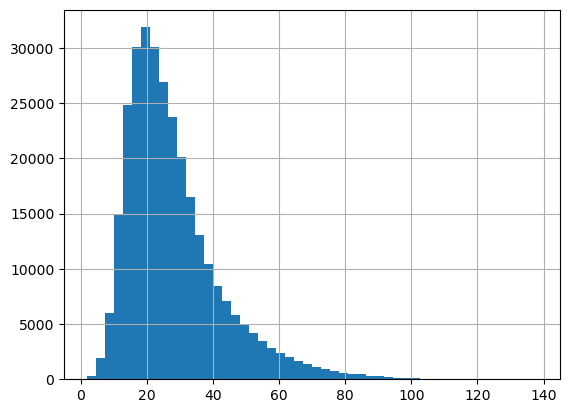

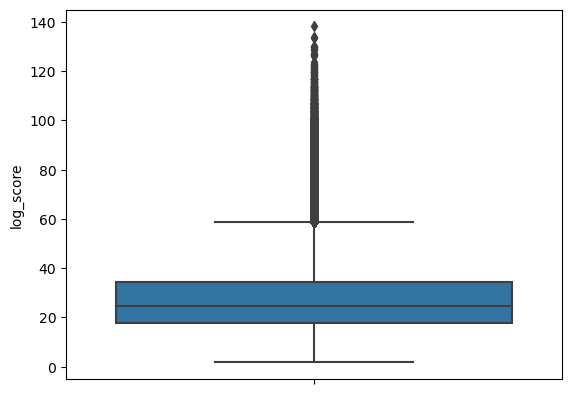

In [30]:
# Univariate Analysis
df_films['log_score'].hist(bins = 50)
plt.show()

sns.boxplot(y='log_score', data=df_films)
plt.show()

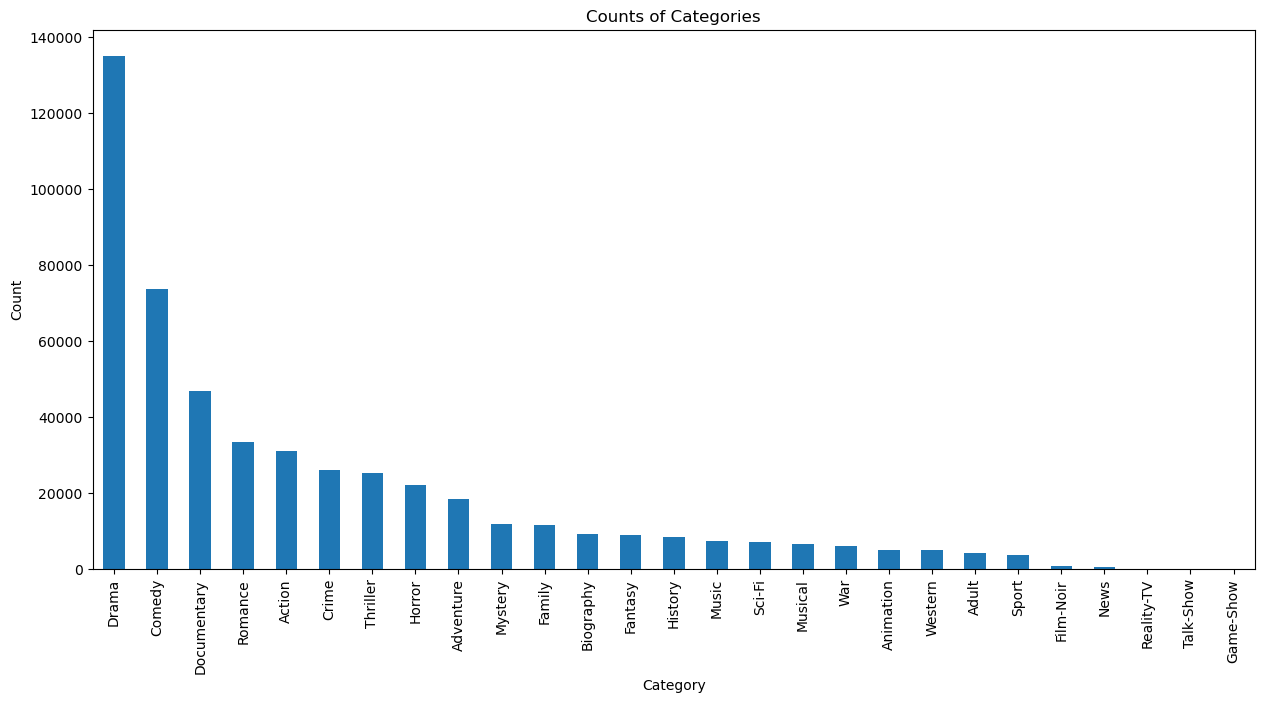

In [31]:
categorical_columns = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 
                       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 
                       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 
                       'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

category_counts = df_films[categorical_columns].sum()

category_counts_sorted = category_counts.sort_values(ascending=False)

# Ploting the counts in a single bar plot
category_counts_sorted.plot(kind='bar', figsize=(15, 7))
plt.title('Counts of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [36]:
import plotly.express as px

genre_counts = df_exploded.groupby(['startYear', 'genres']).size().reset_index(name='count')


fig = px.line(genre_counts, x='startYear', y='count', color='genres', title='Number of Films per Genre Over Years')
fig.show()


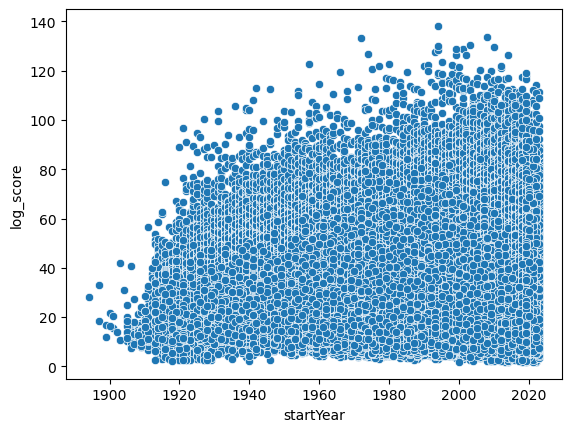

In [32]:
# Bivariate Analysis
sns.scatterplot(x='startYear', y='log_score', data=df_films)
plt.show()

In [33]:
columns = list(categorical_columns)
columns = ['averageRating', 'numVotes', 'log_score'] + columns
df_film_genres = df_films.loc[:, columns]
df_film_genres.head()

averageRating  numVotes  log_score  Action  Adult  Adventure  \
tconst                                                                    
tt0000009            5.3       207  28.263410       0      0          0   
tt0000147            5.3       489  32.819521       0      0          0   
tt0000502            4.1        15  11.103006       0      0          0   
tt0000574            6.0       862  40.555532       1      0          1   
tt0000591            5.0        21  15.222612       0      0          0   

           Animation  Biography  Comedy  Crime  ...  Mystery  News  \
tconst                                          ...                  
tt0000009          0          0       0      0  ...        0     0   
tt0000147          0          0       0      0  ...        0     1   
tt0000502          0          0       0      0  ...        0     0   
tt0000574          0          1       0      0  ...        0     0   
tt0000591          0          0       0      0  ...        0     0   

           Reality-TV  Romance  Sci-Fi  Sport  Talk-Show  Thriller  War  \
tconst                                                                    
tt0000009           0        1       0      0          0         0    0   
tt0000147           0        0       0      1          0         0    0   
tt0000502           0        0       0      0          0         0    0   
tt0000574           0        0       0      0          0         0    0   
tt0000591           0        0       0      0          0         0    0   

           Western  
tconst              
tt0000009        0  
tt0000147        0  
tt0000502        0  
tt0000574        0  
tt0000591        0  

[5 rows x 30 columns]

In [34]:
corr_matrix = df_film_genres.corr(numeric_only = True)
corr_matrix

averageRating  numVotes  log_score    Action     Adult  \
averageRating       1.000000  0.062484   0.331690 -0.110328 -0.055481   
numVotes            0.062484  1.000000   0.384120  0.076666 -0.012083   
log_score           0.331690  0.384120   1.000000  0.069023 -0.072736   
Action             -0.110328  0.076666   0.069023  1.000000 -0.037984   
Adult              -0.055481 -0.012083  -0.072736 -0.037984  1.000000   
Adventure          -0.057662  0.083812   0.067495  0.203527 -0.027224   
Animation           0.018680  0.032255   0.065744  0.045844 -0.013525   
Biography           0.102287  0.020059   0.090937 -0.039251 -0.020505   
Comedy             -0.110806  0.013044   0.084672 -0.052003 -0.020457   
Crime              -0.042899  0.037706   0.114939  0.171138 -0.018695   
Documentary         0.329058 -0.039748  -0.055118 -0.137130 -0.049121   
Drama               0.048983  0.010496   0.155022 -0.050535 -0.080457   
Family              0.005340  0.003147   0.024131 -0.043561 -0.024391   
Fantasy            -0.035120  0.035812   0.046678  0.028206 -0.005171   
Film-Noir           0.011438  0.001360   0.063313 -0.016796 -0.006583   
Game-Show           0.003221 -0.000184  -0.001034 -0.000619 -0.000221   
History             0.077628 -0.000068   0.056638 -0.017900 -0.019255   
Horror             -0.240876  0.009470  -0.016010 -0.029600 -0.022913   
Music               0.067118 -0.002643   0.042526 -0.046322 -0.017814   
Musical             0.001102 -0.008687  -0.004349 -0.036331 -0.017173   
Mystery            -0.047497  0.034860   0.079509 -0.030435 -0.018322   
News                0.035762 -0.004315  -0.004023 -0.015575 -0.005735   
Reality-TV          0.005071 -0.001411  -0.005493 -0.004117 -0.001744   
Romance            -0.018545  0.003192   0.097059 -0.063490 -0.026572   
Sci-Fi             -0.094162  0.067548   0.032160  0.065168 -0.011065   
Sport               0.037079  0.003472   0.043264 -0.011752 -0.011333   
Talk-Show           0.004554 -0.000707  -0.003396 -0.002399  0.007008   
Thriller           -0.124795  0.031138   0.059451  0.057895 -0.030522   
War                 0.024595  0.001115   0.035817  0.000027 -0.017290   
Western            -0.032337 -0.005842  -0.000534 -0.016804 -0.011770   

               Adventure  Animation  Biography    Comedy     Crime  ...  \
averageRating  -0.057662   0.018680   0.102287 -0.110806 -0.042899  ...   
numVotes        0.083812   0.032255   0.020059  0.013044  0.037706  ...   
log_score       0.067495   0.065744   0.090937  0.084672  0.114939  ...   
Action          0.203527   0.045844  -0.039251 -0.052003  0.171138  ...   
Adult          -0.027224  -0.013525  -0.020505 -0.020457 -0.018695  ...   
Adventure       1.000000   0.174021  -0.015054 -0.004842 -0.008762  ...   
Animation       0.174021   1.000000  -0.005664  0.008333 -0.031831  ...   
Biography      -0.015054  -0.005664   1.000000 -0.076228 -0.019477  ...   
Comedy         -0.004842   0.008333  -0.076228  1.000000 -0.045136  ...   
Crime          -0.008762  -0.031831  -0.019477 -0.045136  1.000000  ...   
Documentary    -0.075455  -0.042473   0.172831 -0.222835 -0.110533  ...   
Drama          -0.082163  -0.082927  -0.005682 -0.180583  0.064268  ...   
Family          0.103695   0.101913  -0.010634  0.029782 -0.048568  ...   
Fantasy         0.083521   0.044783  -0.027251  0.019696 -0.040645  ...   
Film-Noir      -0.011852  -0.007177  -0.009011 -0.028468  0.135793  ...   
Game-Show      -0.000468  -0.000241  -0.000327 -0.001039 -0.000563  ...   
History         0.003351  -0.009291   0.183230 -0.079782 -0.036213  ...   
Horror         -0.043479  -0.027611  -0.048687 -0.065211 -0.033156  ...   
Music          -0.031683  -0.010679   0.078741 -0.008503 -0.037031  ...   
Musical        -0.024062  -0.007682  -0.013518  0.079139 -0.033876  ...   
Mystery        -0.021047  -0.022094  -0.033176 -0.066945  0.111822  ...   
News           -0.006534  -0.004083   0.013466 -0.024948 -0.010073  ...   
Reality-TV     -0.001757  

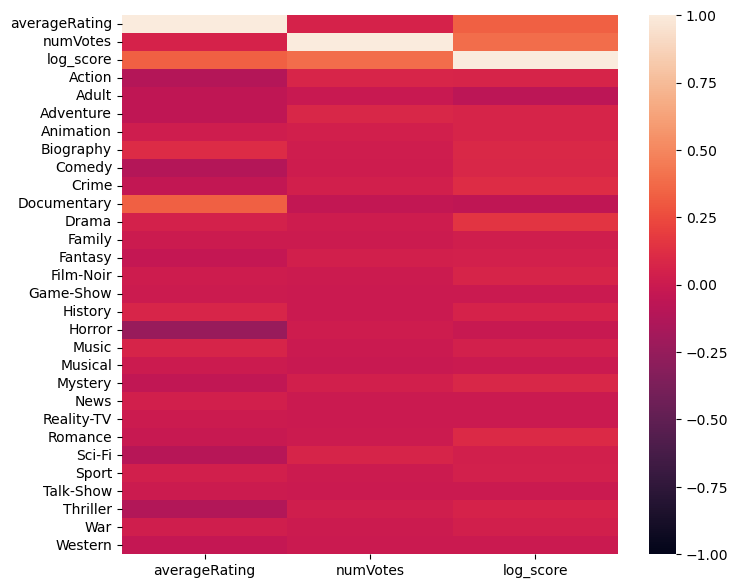

In [35]:
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix[['averageRating', 'numVotes', 'log_score']], vmin=-1, vmax=1)
plt.show()

In [36]:
corr_matrix = df_filtered_genres.corr(numeric_only = True)
corr_matrix

averageRating  numVotes  log_score  \
averageRating                 1.000000  0.089608   0.386539   
numVotes                      0.089608  1.000000   0.386328   
log_score                     0.386539  0.386328   1.000000   
Action,Adventure,Comedy      -0.050995  0.047462   0.029548   
Action,Adventure,Drama       -0.036637  0.041999   0.018983   
Action,Comedy                -0.045801 -0.005367  -0.032096   
Action,Comedy,Crime          -0.023791  0.031699   0.053701   
Action,Crime,Drama           -0.038316  0.020199   0.033416   
Action,Drama                 -0.039229 -0.013369  -0.065671   
Action,Thriller              -0.072862  0.011904  -0.007111   
Biography,Documentary         0.139976 -0.016831  -0.025921   
Comedy,Crime                 -0.031420  0.005810   0.001759   
Comedy,Crime,Drama            0.008766  0.007560   0.049299   
Comedy,Drama                  0.047149 -0.020188   0.015608   
Comedy,Drama,Family           0.020104 -0.004859   0.024166   
Comedy,Drama,Romance          0.023092  0.015027   0.099292   
Comedy,Horror                -0.119981 -0.007026  -0.056176   
Comedy,Musical               -0.021383 -0.014174  -0.063783   
Comedy,Romance               -0.054560 -0.006257  -0.001712   
Crime,Drama                  -0.000983 -0.000892  -0.034507   
Crime,Drama,Mystery           0.007048  0.033318   0.070321   
Crime,Drama,Thriller         -0.001882  0.025635   0.063517   
Documentary,Drama             0.101989 -0.013419  -0.040441   
Documentary,History           0.118856 -0.013411  -0.022665   
Documentary,Music             0.173238 -0.017483  -0.007005   
Drama,Family                  0.057163 -0.015913  -0.042841   
Drama,History                 0.042995 -0.011446  -0.007089   
Drama,Romance                 0.039256 -0.018977  -0.010588   
Drama,Thriller               -0.024475 -0.007480  -0.010980   
Drama,War                     0.040831 -0.007346  -0.006557   
Drama,Western                -0.011165 -0.002856  -0.008986   
Horror,Mystery,Thriller      -0.094033  0.024956   0.015505   
Horror,Thriller              -0.197878 -0.004863  -0.056341   

                         Action,Adventure,Comedy  Action,Adventure,Drama  \
averageRating                          -0.050995               -0.036637   
numVotes                                0.047462                0.041999   
log_score                               0.029548                0.018983   
Action,Adventure,Comedy                 1.000000               -0.017660   
Action,Adventure,Drama                 -0.017660                1.000000   
Action,Comedy                          -0.016019               -0.017621   
Action,Comedy,Crime                    -0.015586               -0.017144   
Action,Crime,Drama                     -0.026842               -0.029526   
Action,Drama                           -0.024612               -0.027073   
Action,Thriller                        -0.016062               -0.017668   
Biography,Documentary                  -0.019819               -0.021800   
Comedy,Crime                           -0.016574               -0.018231   
Comedy,Crime,Drama                     -0.016069               -0.017676   
Comedy,Drama                           -0.049823               -0.054804   
Comedy,Drama,Family                    -0.015111               -0.016621   
Comedy,Drama,Romance                   -0.032939               -0.036232   
Comedy,Horror                          -0.018111               -0.019921   
Comedy,Musical                         -0.016807               -0.018487   
Comedy,Romance                         -0.036268               -0.039894   
Crime,Drama                            -0.030153               -0.033167   
Crime,Drama,Mystery                    -0.017318               -0.019049   
Crime,Drama,Thriller                   -0.021028               -0.023131   
Documentary,Drama                      -0.015490               -0.017039   
Documentary,History                    -0.015681          

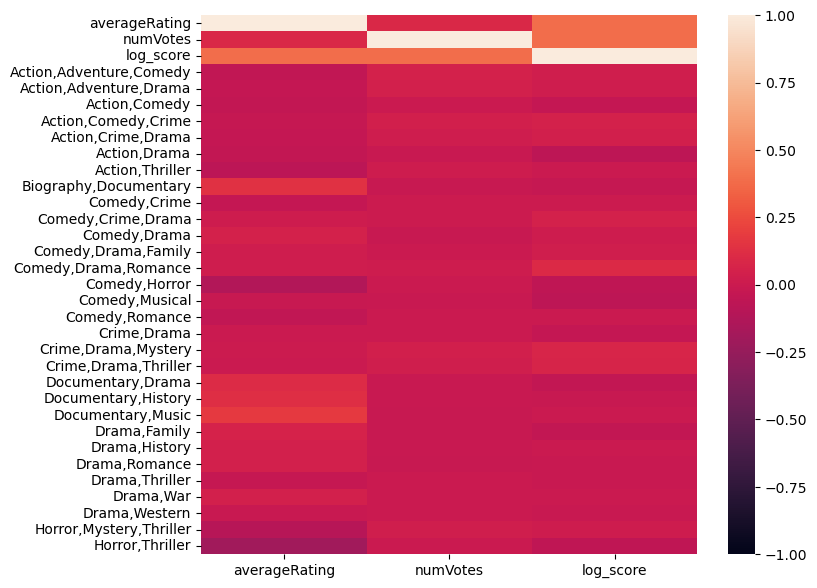

In [37]:
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix[['averageRating', 'numVotes', 'log_score']], vmin=-1, vmax=1 )
plt.show()

In [38]:
df_film_stats = df_films.iloc[:, :9]
df_film_stats.head()

averageRating  numVotes  log_score  pocet_prekladov  \
tconst                                                           
tt0000009            5.3       207  28.263410                4   
tt0000147            5.3       489  32.819521                2   
tt0000502            4.1        15  11.103006                1   
tt0000574            6.0       862  40.555532                8   
tt0000591            5.0        21  15.222612                2   

                            primaryTitle  isAdult  startYear  runtimeMinutes  \
tconst                                                                         
tt0000009                     Miss Jerry        0     1894.0            45.0   
tt0000147  The Corbett-Fitzsimmons Fight        0     1897.0           100.0   
tt0000502                       Bohemios        0     1905.0           100.0   
tt0000574    The Story of the Kelly Gang        0     1906.0            70.0   
tt0000591               The Prodigal Son        0     1907.0            90.0   

           year_diff  
tconst                
tt0000009      130.0  
tt0000147      127.0  
tt0000502      119.0  
tt0000574      118.0  
tt0000591      117.0

In [39]:
# Correlation Matrix
corr_matrix = df_film_stats.corr(numeric_only = True)
corr_matrix

averageRating  numVotes  log_score  pocet_prekladov  \
averageRating         1.000000  0.062484   0.331690        -0.003536   
numVotes              0.062484  1.000000   0.384120         0.463379   
log_score             0.331690  0.384120   1.000000         0.727591   
pocet_prekladov      -0.003536  0.463379   0.727591         1.000000   
isAdult              -0.060505 -0.012464  -0.076399        -0.046761   
startYear             0.060238  0.030535   0.054961        -0.065837   
runtimeMinutes        0.009288  0.017080   0.047891         0.029955   
year_diff            -0.060238 -0.030535  -0.054961         0.065837   

                  isAdult  startYear  runtimeMinutes  year_diff  
averageRating   -0.060505   0.060238        0.009288  -0.060238  
numVotes        -0.012464   0.030535        0.017080  -0.030535  
log_score       -0.076399   0.054961        0.047891  -0.054961  
pocet_prekladov -0.046761  -0.065837        0.029955   0.065837  
isAdult          1.000000  -0.061814       -0.015215   0.061814  
startYear       -0.061814   1.000000        0.019390  -1.000000  
runtimeMinutes  -0.015215   0.019390        1.000000  -0.019390  
year_diff        0.061814  -1.000000       -0.019390   1.000000

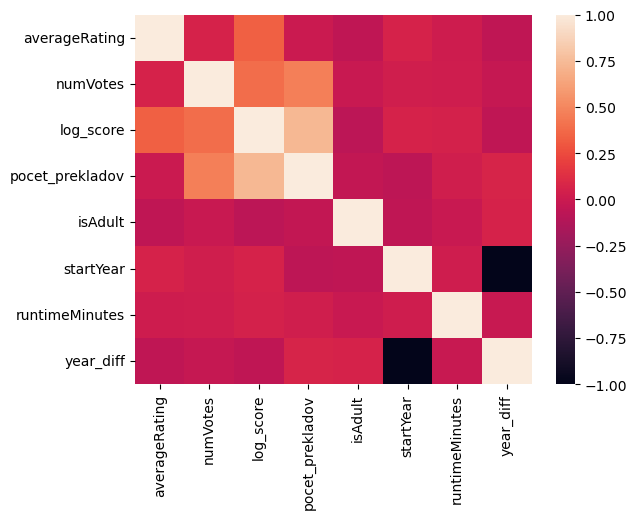

In [40]:
sns.heatmap(corr_matrix, vmin=-1, vmax=1 )
plt.show()

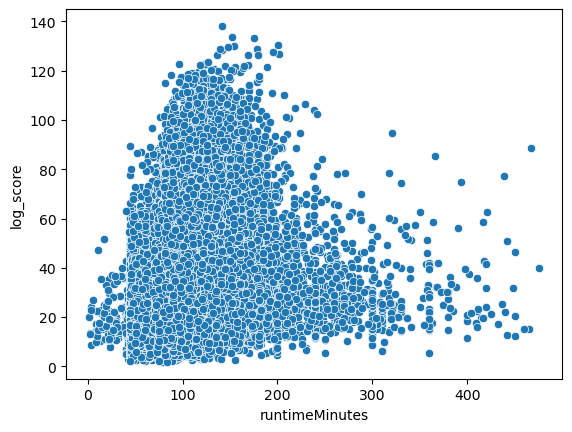

In [41]:
sns.scatterplot(x='runtimeMinutes', y='log_score', 
                data=df_film_stats[(df_film_stats['runtimeMinutes'] < 480)])
plt.show()

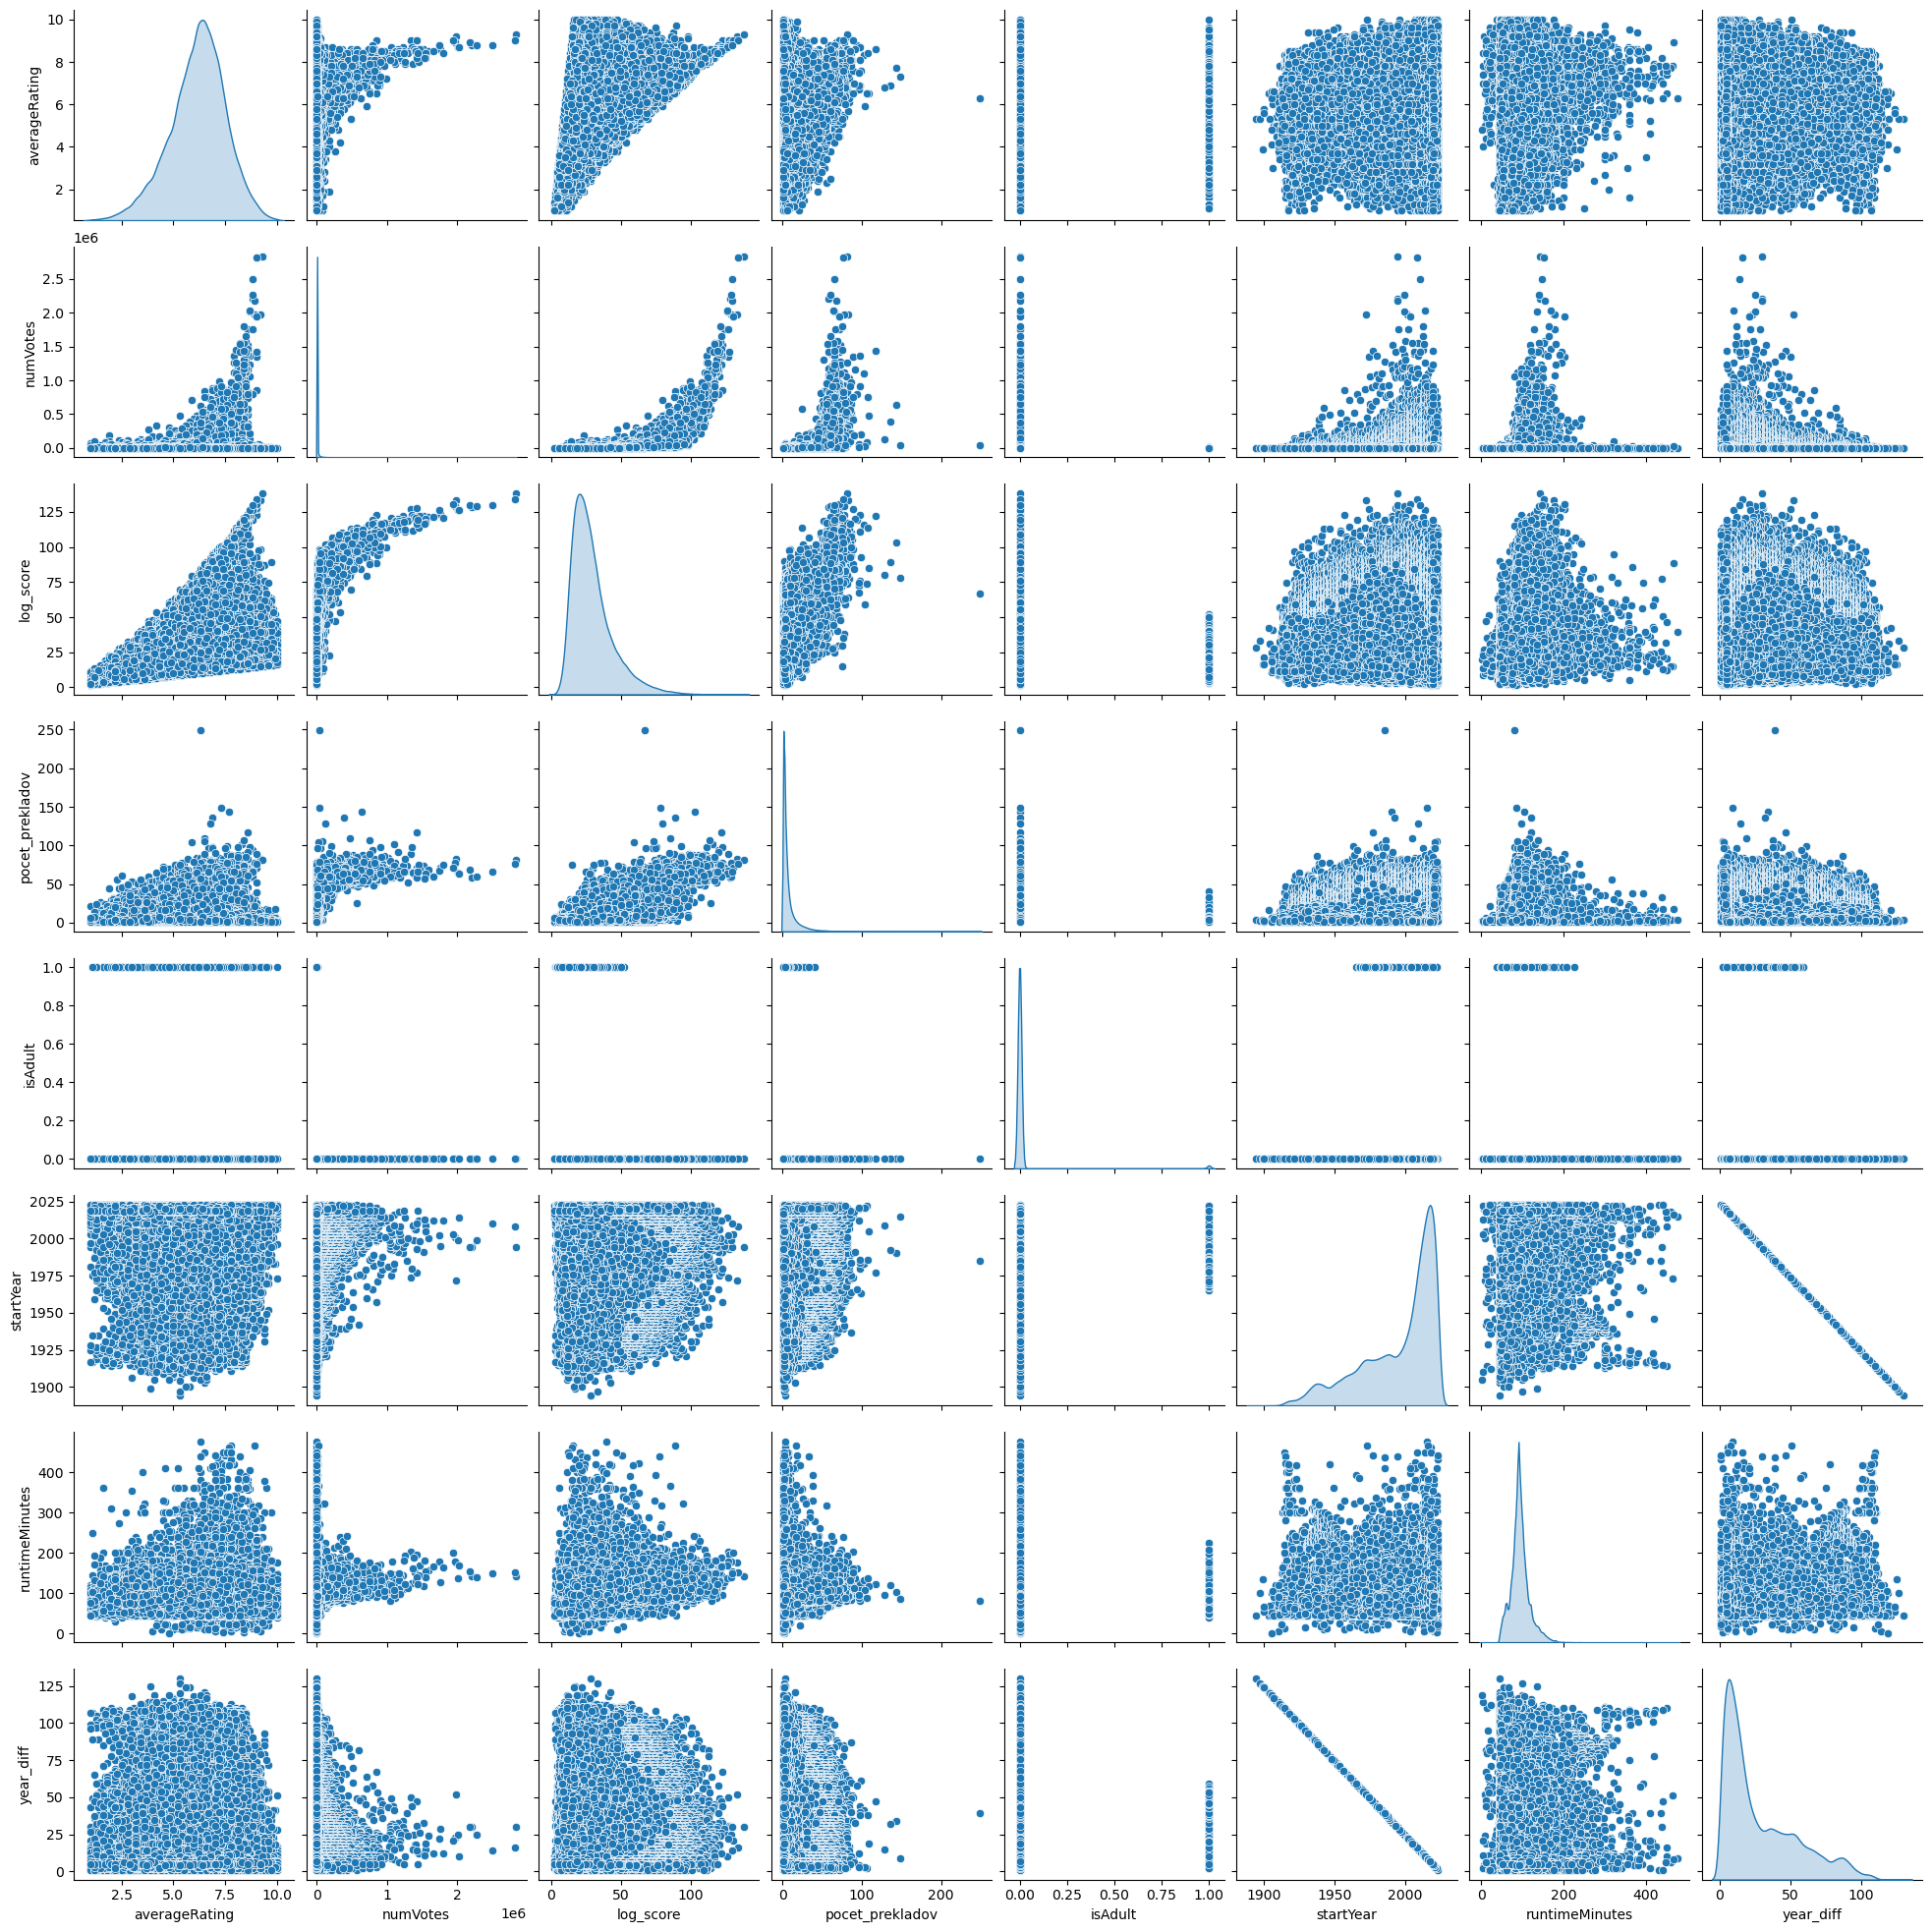

In [54]:
# Pair Plot
sns.pairplot(df_film_stats[(df_film_stats['runtimeMinutes'] < 480)], diag_kind='kde')
plt.show()

# Statistical Analysis

In [56]:
from scipy import stats

### Functions

In [62]:
def test_normality(data):
    if len(data) <= 5000:
        stat, p_value = stats.shapiro(data)
        print(f'Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}')
    else:
        stat, p_value = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
        print(f'Kolmogorov-Smirnov Test: Statistics={stat}, p-value={p_value}')
    if p_value > 0.05:
        print("Our data is most likely from Normal distribution.")
    else:
        print("Our data is not from Normal distribution.")

def qq_plot(data, title):
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(title)
    plt.show()
    
def histogram(data):
    fig, ax1 = plt.subplots()

    sns.histplot(data, ax=ax1, color='blue', alpha=0.5)
    ax1.set_xlabel("Score")
    ax1.set_ylabel("Frequency", color='blue')

    ax2 = ax1.twinx()
    sns.kdeplot(data, ax=ax2, color='red', linewidth=2)
    ax2.set_ylabel("KDE", color='red')

    ax1.grid(axis='y', linestyle='--', alpha=0.6)
    ax2.grid(False)

    plt.title("Score Distribution with KDE")
    plt.show()
       
def hypothesis_test(x, y, alternative):
    if stats.shapiro(x)[1] > 0.05 and stats.shapiro(y)[1] > 0.05:
        # IF both groups are normally distributed then we use student's t-test
        stat, p = stats.ttest_ind(x, y, alternative=alternative)
        print(f'T-test: Statistics={stat}, p-value={p}')
    else:
        # IF at least one group is not normally distributed we use Mann-Whitney U test
        stat, p = stats.mannwhitneyu(x, y, alternative=alternative)
        print(f'Mann-Whitney U Test: Statistics={stat}, p-value={p}')

    if p > 0.05:
        print("Fail to reject the null hypothesis (H0)")
    else:
        print("Reject the null hypothesis (H0), accept the alternative hypothesis (H1)")

## Directors testing

### Normality testing 

In [57]:
x = np.array(avg_ls_best.loc[:, 'avg_log_score'])  # Best directors avg_log_score
y = np.array(avg_ls_worst.loc[:, 'avg_log_score'])  # Worst directors avg_log_score
print(x.shape, y.shape)

(17,) (17,)


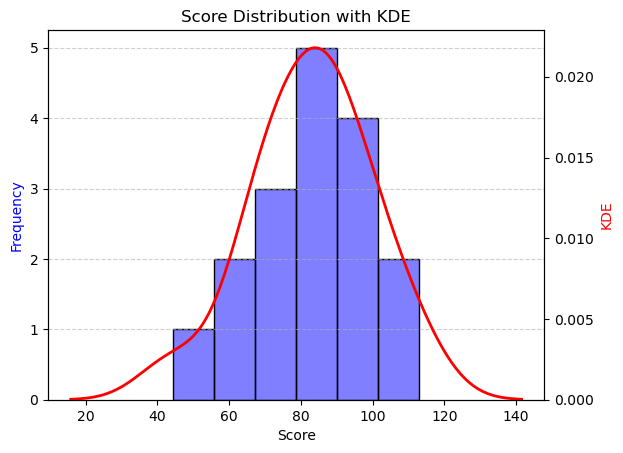

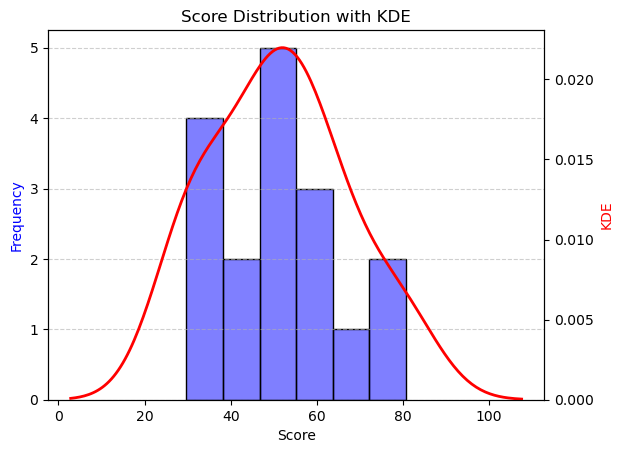

In [87]:
histogram(x)
histogram(y)

Testing normality for x:
Shapiro-Wilk Test: Statistics=0.9850751161575317, p-value=0.9893240332603455
Our data is most likely from Normal distribution.

Testing normality for y:
Shapiro-Wilk Test: Statistics=0.9439724087715149, p-value=0.36836737394332886
Our data is most likely from Normal distribution.


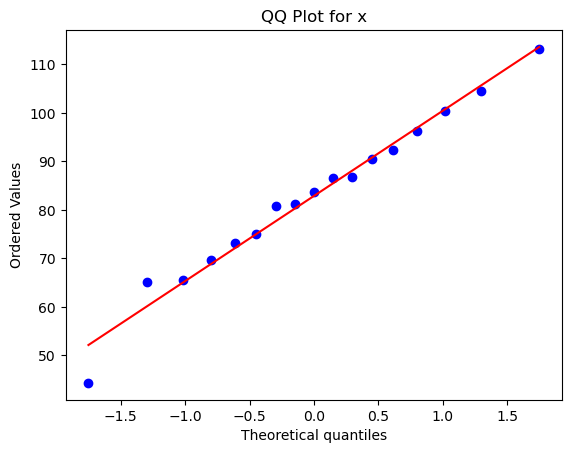

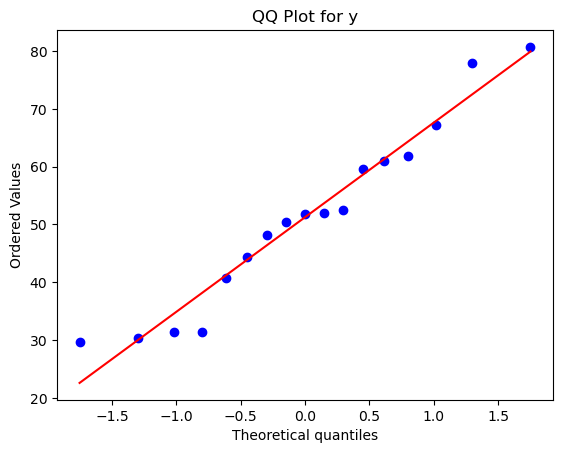

In [155]:
print("Testing normality for x:")
test_normality(x)
print("\nTesting normality for y:")
test_normality(y)

qq_plot(x, "QQ Plot for x")
qq_plot(y, "QQ Plot for y")

### Hypothesis testing (H0: μx <= μy vs. H1: μx > μy)

In [156]:
hypothesis_test(x, y, 'greater')

T-test: Statistics=5.670252762932982, p-value=1.412755171097551e-06
Reject the null hypothesis (H0), accept the alternative hypothesis (H1)


## Translation testing

### Normality testing

In [48]:
preklad_median = np.median(df_film_stats['pocet_prekladov'])

In [52]:
#median prekladov = 3
malo_prekladov = df_film_stats[df_film_stats['pocet_prekladov'] <= 3]
vela_prekladov = df_film_stats[df_film_stats['pocet_prekladov'] > 3]
print(malo_prekladov.shape, vela_prekladov.shape)

(161199, 9) (139615, 9)


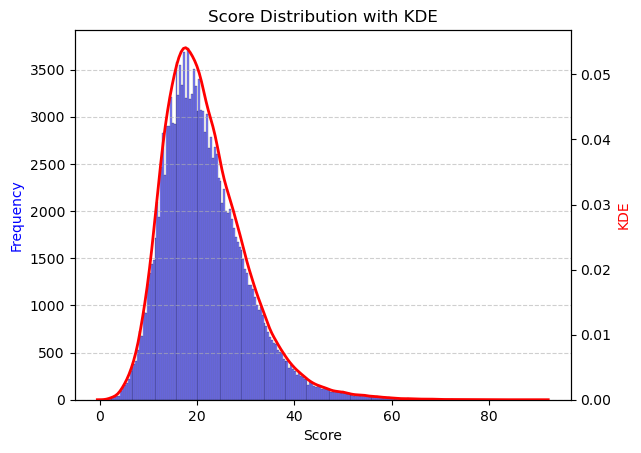

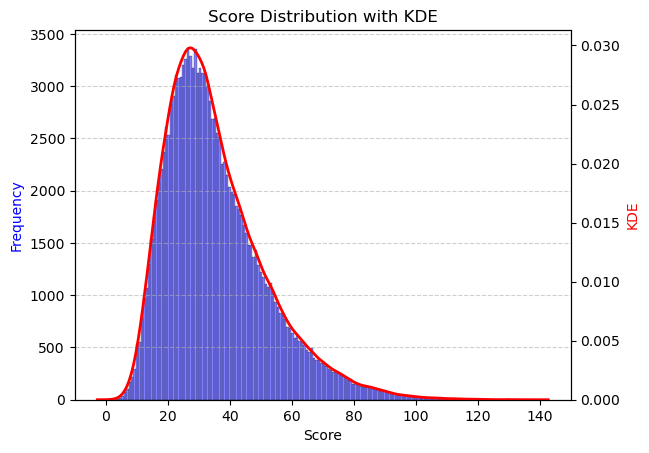

In [67]:
histogram(malo_prekladov['log_score'])
histogram(vela_prekladov['log_score'])

Testing normality for x:
Kolmogorov-Smirnov Test: Statistics=0.06704653027963114, p-value=0.0
Our data is not from Normal distribution.

Testing normality for y:
Kolmogorov-Smirnov Test: Statistics=0.08450285348146014, p-value=0.0
Our data is not from Normal distribution.


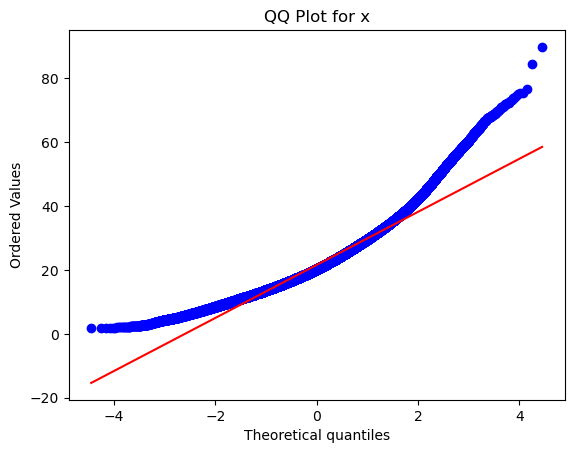

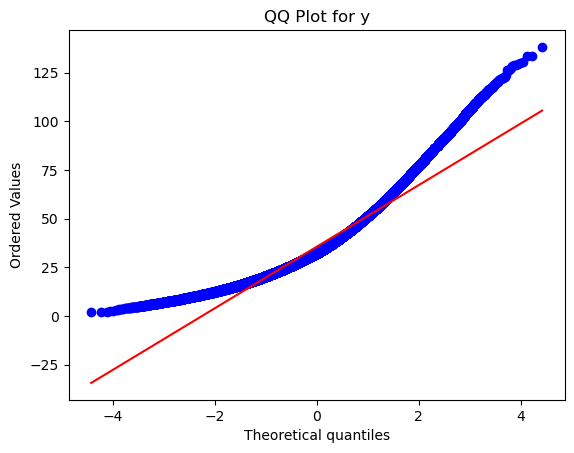

In [66]:
print("Testing normality for x:")
test_normality(malo_prekladov['log_score'])
print("\nTesting normality for y:")
test_normality(vela_prekladov['log_score'])

qq_plot(malo_prekladov['log_score'], "QQ Plot for x")
qq_plot(vela_prekladov['log_score'], "QQ Plot for y")

### Hypothesis testing (H0: μx >= μy vs. H1: μx < μy)

In [74]:
hypothesis_test(malo_prekladov['log_score'], vela_prekladov['log_score'], 'less')

Mann-Whitney U Test: Statistics=4900020717.5, p-value=0.0
Reject the null hypothesis (H0), accept the alternative hypothesis (H1)


## Visualisation and analysis

### Functions

In [49]:
def diff_of_avg_log(data, analyzed_data, title):
    
    data_mean = np.mean(data['log_score'])
    data = data.reset_index()
    data.rename(columns={'index': 'tconst'}, inplace=True)
    excluded_data = data[~data['tconst'].isin(analyzed_data['tconst'])]
    excluded_data_mean = np.mean(excluded_data['log_score'])
    
    diff = excluded_data_mean - data_mean
    result = - round(diff / data_mean * 100, 2)
    
    plt.figure(figsize=(10, 6))

    # Plotting the first dataset
    sns.scatterplot(x='startYear', y='log_score', data=data, hue=0.5, label='All data')

    # Plotting the second dataset
    sns.scatterplot(x='startYear', y='log_score', data=data[data['tconst'].isin(analyzed_data['tconst'])], 
                    color='red', label='Excluded data')

    plt.axhline(y=data_mean, color='blue', linestyle='--', label='Threshold')

    # Adding labels and title
    plt.xlabel('Start Year')
    plt.ylabel('Log Score')
    plt.title(title)

    # Display the plot
    plt.legend()
    plt.show()
    
    if diff >= 0:
        return print(f"Analyzed movies had negative or no impact on the mean log_score of the whole data.\nThe significance of the impact is {result}%.")
    else:
        return print(f"Analyzed movies had a positive impact on the mean log_score of the whole data.\nThe significance of the impact is {result}%.")


### Greatest Actors

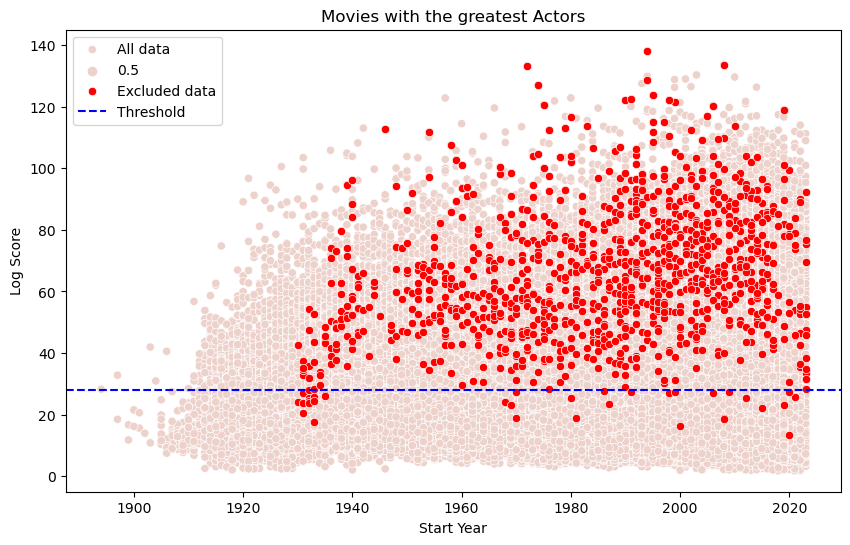

Analyzed movies had a positive impact on the mean log_score of the whole data.
The significance of the impact is 0.49%.


In [50]:
diff_of_avg_log(df_film_stats, df_films_with_top_actors, 'Movies with the greatest Actors')

### Disabilities

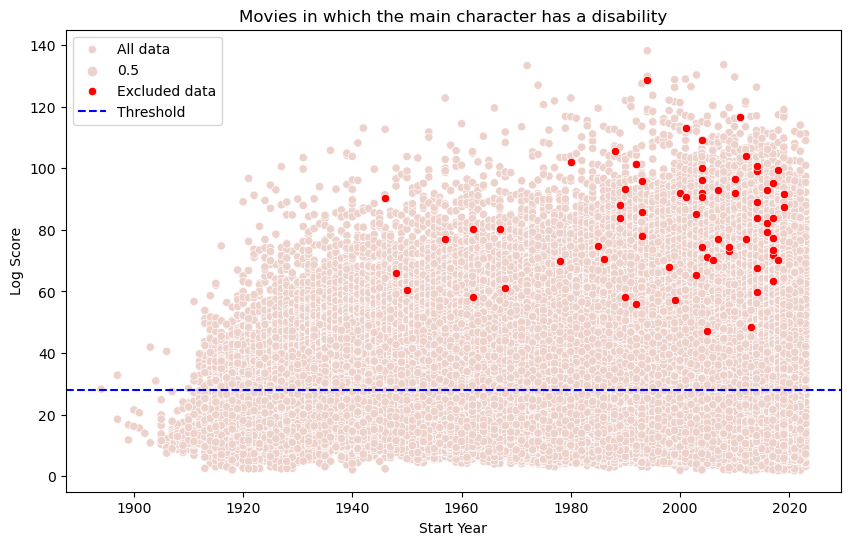

Analyzed movies had a positive impact on the mean log_score of the whole data.
The significance of the impact is 0.05%.


In [51]:
diff_of_avg_log(df_film_stats, df_disability, 'Movies in which the main character has a disability')

### Adults

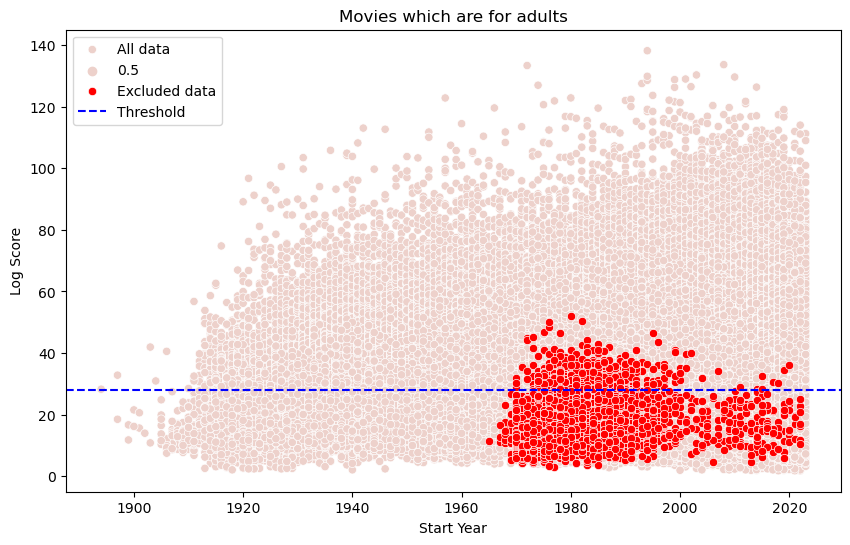

Analyzed movies had negative or no impact on the mean log_score of the whole data.
The significance of the impact is -0.5%.


In [52]:
adult_data = df_film_stats[df_film_stats['isAdult'] == 1].reset_index()
adult_data.rename(columns={'index': 'tconst'}, inplace=True)
diff_of_avg_log(df_film_stats, adult_data, 'Movies which are for adults')